## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # Install additional dependencies
# !pip install matplotlib pandas pillow torchtnt tqdm

# # Install extra dependencies for pandas
# !pip install tabulate pyarrow fastparquet

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_yolox_pytorch cjm_torchvision_tfms

In [2]:
# !pip install nncf

In [3]:
# !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

## Importing the Required Dependencies

In [4]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import YOLOX package
from cjm_yolox_pytorch.model import build_model, MODEL_CFGS, NORM_STATS
from cjm_yolox_pytorch.utils import generate_output_grids
from cjm_yolox_pytorch.loss import YOLOXLoss
from cjm_yolox_pytorch.inference import YOLOXInferenceWrapper

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw, ImageFont

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [5]:
import nncf

## Setting Up the Project

### Setting a Random Number Seed

In [6]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [7]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

### Set the Directory Paths

In [8]:
# The name for the project
project_name = f"pytorch-yolox-object-detector"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2023-08-17_16-14-43")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-yolox-object-detector
Checkpoint Directory:,pytorch-yolox-object-detector/2023-08-17_16-14-43


### Download a Font File

In [9]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Loading the Checkpoint Data

### Load the Colormap

In [10]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

### Load the Normalization Statistics

In [11]:
# The normalization stats path
norm_stats_path = checkpoint_dir/'norm_stats.json'

# Read the normalization stats from the JSON file
with open(norm_stats_path, "r") as f:
    norm_stats_dict = json.load(f)

# Convert the dictionary to a tuple
norm_stats = (norm_stats_dict["mean"], norm_stats_dict["std_dev"])

# Print the mean and standard deviation
pd.DataFrame(norm_stats)

,0,1,2
0,0.5,0.5,0.5
1,1.0,1.0,1.0


### Load the Model Checkpoint

In [12]:
# The model checkpoint path
checkpoint_path = list(checkpoint_dir.glob('*.pth'))[0]

# Load the model checkpoint onto the CPU
model_checkpoint = torch.load(checkpoint_path, map_location='cpu')

### Load the Trained YOLOX Model

In [13]:
# Select the YOLOX model configuration
model_type = checkpoint_path.stem

# Create a YOLOX model with the number of output classes equal to the number of class names
model = build_model(model_type, len(class_names))

# Get stride values for processing output
strides = model.bbox_head.strides

# Initialize the model with the checkpoint parameters and buffers
model.load_state_dict(model_checkpoint)

The file ./pretrained_checkpoints/yolox_tiny.pth already exists and overwrite is set to False.


<All keys matched successfully>

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [14]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,/mnt/980_1TB_2/Datasets
Archive Directory:,/mnt/980_1TB_2/Datasets/../Archive


### Setting the Dataset Path

In [15]:
# Set the name of the dataset
dataset_name = 'hagrid-sample-30k-384p'
# dataset_name = 'hagrid-sample-120k-384p'
# dataset_name = 'hagrid-sample-250k-384p'
# dataset_name = 'hagrid-sample-500k-384p'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/hagrid-sample-30k-384p
Archive Path:,/mnt/980_1TB_2/Datasets/../Archive/hagrid-sample-30k-384p.zip
Dataset Path:,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p


### Downloading the Dataset

In [16]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/hagrid-sample-30k-384p/resolve/main/hagrid-sample-30k-384p.zip
Dataset folder already exists


### Getting the Image and Annotation Folders

In [17]:
# Create a list of the items in the 'dataset_path' directory
dir_content = [item for item in dataset_path.iterdir() if item.is_dir()]

# Get the path of the 'ann_train_val' directory
annotation_dir = dataset_path/'ann_train_val'

# Remove the 'ann_train_val' directory from the list of items
dir_content.remove(annotation_dir)

# Get the path of the remaining directory, which is assumed to be the image directory
img_dir = dir_content[0]

# Print the paths of the annotation and image directories
print(f"Annotation Directory: {annotation_dir}")
print(f"Image Directory: {img_dir}")

# Get a list of files in the 'annotation_dir' directory
annotation_file_paths = list(annotation_dir.glob('*.json'))

# Get a list of folders in the 'img_dir' directory
img_folder_paths = [folder for folder in img_dir.iterdir() if folder.is_dir()]

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]})

Annotation Directory: /mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/ann_train_val
Image Directory: /mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k


,Image Folder,Annotation File
0,train_val_call,call.json
1,train_val_dislike,dislike.json
2,train_val_fist,fist.json
3,train_val_four,four.json
4,train_val_like,like.json
5,train_val_mute,mute.json
6,train_val_ok,ok.json
7,train_val_one,one.json
8,train_val_palm,palm.json
9,train_val_peace,peace.json


### Get Image File Paths

In [18]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for folder in img_folder_paths # Iterate through each image folder
    for file in get_img_files(folder) # Get a list of image files in each image folder
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 31833


,0
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00005c9c-3548-4a8f-9d0b-2dd4aff37fc9.jpg
0020a3db-82d8-47aa-8642-2715d4744db5,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/0020a3db-82d8-47aa-8642-2715d4744db5.jpg
004ac93f-0f7c-49a4-aadc-737e0ad4273c,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/004ac93f-0f7c-49a4-aadc-737e0ad4273c.jpg
006cac69-d3f0-47f9-aac9-38702d038ef1,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/006cac69-d3f0-47f9-aac9-38702d038ef1.jpg
00973fac-440e-4a56-b60c-2a06d5fb155d,/mnt/980_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00973fac-440e-4a56-b60c-2a06d5fb155d.jpg


### Get Bounding Box Annotations

In [19]:
# Set the file path for the annotations DataFrame
annotation_df_pq_path = dataset_path/'annotations_df.parquet'

if annotation_df_pq_path.is_file():
    # Load the annotations DataFrame if present
    annotation_df = pd.read_parquet(annotation_df_pq_path)
else:
    # Create a generator that yields Pandas DataFrames containing the data from each JSON file
    cls_dataframes = (pd.read_json(f).transpose() for f in tqdm(annotation_file_paths))

    # Concatenate the DataFrames into a single DataFrame
    annotation_df = pd.concat(cls_dataframes, ignore_index=False)

    # Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
    annotation_df = annotation_df.loc[list(img_dict.keys())]

    # Save the annotations DataFrame to disk
    annotation_df.to_parquet(annotation_df_pq_path)

# Print the first 5 rows of the DataFrame
annotation_df.head()

,bboxes,labels,leading_hand,leading_conf,user_id
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9,"[[0.23925175, 0.28595301, 0.25055143, 0.20777627]]",[call],right,1.0,5a389ffe1bed6660a59f4586c7d8fe2770785e5bf79b09334aa951f6f119c024
0020a3db-82d8-47aa-8642-2715d4744db5,"[[0.5801012999999999, 0.53265105, 0.14562138, 0.12286348]]",[call],left,1.0,0d6da2c87ef8eabeda2dcfee2dc5b5035e878137a91b149c754a59804f3dce32
004ac93f-0f7c-49a4-aadc-737e0ad4273c,"[[0.46294793, 0.26419774, 0.13834939000000002, 0.10784189]]",[call],right,1.0,d50f05d9d6ca9771938cec766c3d621ff863612f9665b0e4d991c086ec04acc9
006cac69-d3f0-47f9-aac9-38702d038ef1,"[[0.38799208, 0.44643898, 0.27068787, 0.18277858]]",[call],right,1.0,998f6ad69140b3a59cb9823ba680cce62bf2ba678058c2fc497dbbb8b22b29fe
00973fac-440e-4a56-b60c-2a06d5fb155d,"[[0.40980118, 0.38144198, 0.08338464, 0.06229785], [0.6122035100000001, 0.6780825500000001, 0.04700606, 0.07640522]]","[call, no_gesture]",right,1.0,4bb3ee1748be58e05bd1193939735e57bb3c0ca59a7ee38901744d6b9e94632e


### Inspecting the Class Distribution

#### Get image classes

In [20]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = annotation_df['labels'].explode().unique().tolist()
class_names.sort()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


#### Visualize the class distribution

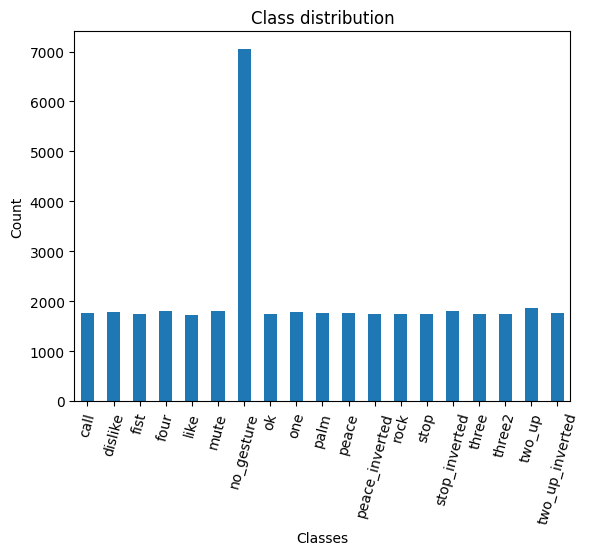

In [21]:
# Get the number of samples for each object class
class_counts = annotation_df['labels'].explode().value_counts().sort_index()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Bounding Box Annotations

#### Define the bounding box annotation function

In [22]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (384, 512)


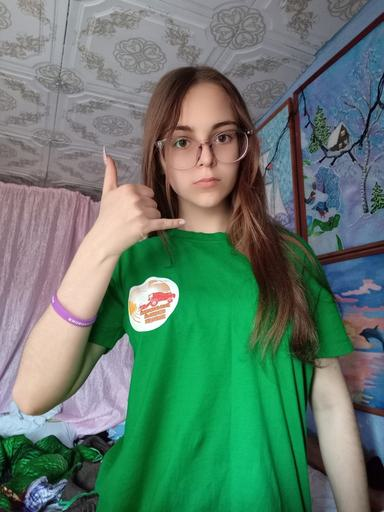

In [23]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [24]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,00005c9c-3548-4a8f-9d0b-2dd4aff37fc9
bboxes,"[[0.23925175, 0.28595301, 0.25055143, 0.20777627]]"
labels,[call]
leading_hand,right
leading_conf,1.0
user_id,5a389ffe1bed6660a59f4586c7d8fe2770785e5bf79b09334aa951f6f119c024


#### Annotate sample image

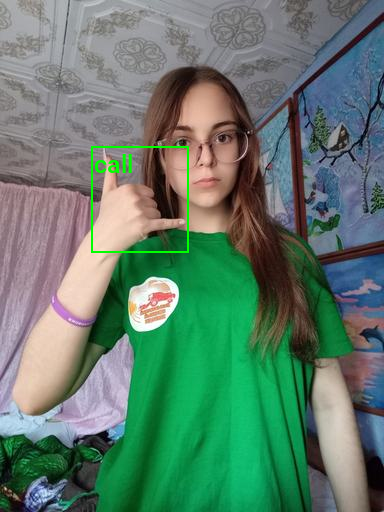

In [25]:
# Extract the labels and bounding box annotations for the sample image
labels = annotation_df.loc[file_id]['labels']
bboxes = annotation_df.loc[file_id]['bboxes']

# Calculate the bounding boxes in the image size scale
width, height = sample_img.size
bboxes = [[x*width, y*height, w*width, h*height] for x, y, w, h in bboxes]

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'), 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Training-Validation Split

In [26]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

val_pct = 0.1
val_split = int(len(img_keys)*val_pct)

# Split the subset of image paths into training and validation sets
val_keys = img_keys[:val_split]

# Print the number of images in the training and validation sets
pd.Series({
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

Validation Samples:,3183


### Data Augmentation

#### Set training image size

In [27]:
# Show a list of potential input resolutions
print([max(strides)*i for i in range(7,21)])

# Set training image size to a multiple of the max stride value
train_sz = 384

[224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640]


#### Initialize the transforms

In [28]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

In [29]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

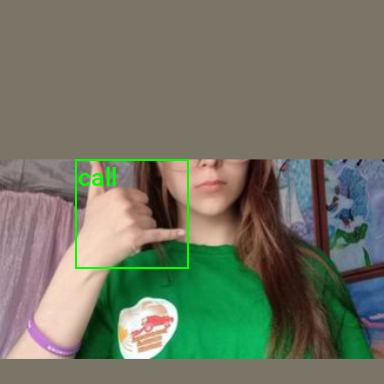

Source Image:,"(384, 512)"
Cropped Image:,"(326, 169)"
Resized Image:,"(383, 199)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [30]:
# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'), 
                                format='xyxy', 
                                canvas_size=sample_img.size[::-1]), 
           'labels': labels}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(resized_padded_img), 
    boxes=targets['boxes'], 
    labels=targets['labels'], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [31]:
class HagridDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding bounding box annotations and labels.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Constructor for the HagridDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Retrieve the key for the image at the specified index
        img_key = self._img_keys[index]
        # Get the annotations for this image
        annotation = self._annotation_df.loc[img_key]
        # Load the image and its target (bounding boxes and labels)
        image, target = self._load_image_and_target(annotation)
        
        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """
        # Retrieve the file path of the image
        filepath = self._img_dict[annotation.name]
        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')
        # Calculate the bounding boxes in the image size scale
        bbox_list = np.array([bbox*(image.size*2) for bbox in annotation.bboxes])
        
        # Convert bounding box coordinates from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax]
        bbox_tensor = torchvision.ops.box_convert(torch.Tensor(bbox_list), 'xywh', 'xyxy')
        # Create a BoundingBoxes object with the bounding boxes
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
        # Convert the class labels to indices
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation.labels])
        return image, {'boxes': boxes, 'labels': labels}

### Image Transforms

In [32]:
# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
    transforms.Normalize(*norm_stats),
])

valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [33]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
valid_dataset = HagridDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

Validation dataset size:,3183


### Inspect Samples

#### Inspect validation set sample

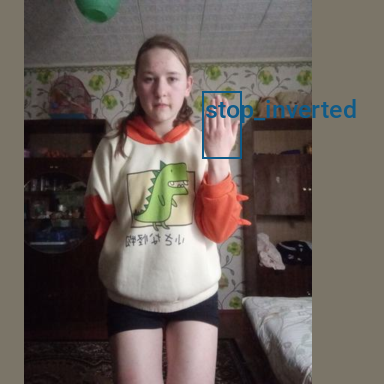

In [34]:
dataset_sample = valid_dataset[0]

annotated_tensor = draw_bboxes(
    image=(denorm_img_tensor(dataset_sample[0], *norm_stats)*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)

### Initialize DataLoaders

In [35]:
# Set the training batch size
# bs = 32
bs = 1

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'collate_fn': lambda batch: tuple(zip(*batch)),
    'drop_last': True,
    'prefetch_factor': 8,
    'pin_memory': True,
    'pin_memory_device': device
}

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')

Number of batches in validation DataLoader:,3183


In [36]:
def transform_fn(data_item):
    # print(data_item[0].shape)
    images, _ = data_item
    return images[0][None]

In [37]:
calibration_dataset = nncf.Dataset(valid_dataloader, transform_fn)

In [38]:
# list(calibration_dataset.get_data([0]))

In [39]:
quantized_model = nncf.quantize(model=model, 
                                calibration_dataset=calibration_dataset, 
                                preset=nncf.QuantizationPreset.PERFORMANCE, 
                                target_device=nncf.TargetDevice.ANY, 
                                subset_size=300, 
                                fast_bias_correction=True, 
                                model_type=None, 
                                ignored_scope=None, 
                                advanced_parameters=None)

2023-12-06 15:51:37.992329: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 15:51:38.017575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 15:51:38.656281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Output()

Output()

In [40]:
# assert False

## Exporting the Model to ONNX

### Prepare the Model for Inference

In [41]:
# Convert the normalization stats to tensors
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
model.eval();

# Wrap the model with preprocessing and post-processing steps
wrapped_model = YOLOXInferenceWrapper(quantized_model, 
                                      mean_tensor, 
                                      std_tensor, 
                                      scale_inp=False, # Scale input values from the rang [0,255] to [0,1]
                                      channels_last=False, # Have the model expect input in channels-last format
                                      run_box_and_prob_calculation=False # Enable or disable post-processing steps
                                     )

# Get the slice object for extracting the input dimensions
input_dim_slice = wrapped_model.input_dim_slice
input_dim_slice

slice(2, 4, None)

### Prepare the Input Tensor

In [42]:
input_tensor = torch.randn(1, 3, 256, 256)

### Export the Model to ONNX

In [43]:
# Set a filename for the ONNX model
onnx_file_path = f"{checkpoint_dir}/{colormap_path.stem.removesuffix('-colormap')}-{model_type}-nncf.onnx"

# Export the PyTorch model to ONNX format
torch.onnx.export(wrapped_model.cpu(),
                  input_tensor.cpu(),
                  onnx_file_path,
                  export_params=True,
                  do_constant_folding=False,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input': {input_dim_slice.start : 'height', input_dim_slice.stop-1 : 'width'}}
                 )

/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/nncf/torch/quantization/layers.py:333: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self._level_low.item()
/home/innom-dt/mambaforge/envs/pytorch-env/lib/python3.11/site-packages/nncf/torch/quantization/layers.py:341: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self._level_high.item()


In [44]:
# assert False

In [45]:
import openvino.runtime as ov
from openvino import convert_model

In [46]:
# convert ONNX model to OpenVINO model
ov_quantized_model = convert_model(onnx_file_path)

# compile the model to transform quantized operations to int8
compiled_model_int8 = ov.compile_model(ov_quantized_model, device_name='CPU')

In [47]:
input_tensor_np = np.random.randn(1, 3, 256, 256).astype(np.float32)

In [48]:
%%timeit
compiled_model_int8(input_tensor_np)

2.59 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
ov_file_path = f"{checkpoint_dir}/{Path(onnx_file_path).stem}-int8.xml"

In [50]:
# save the model
ov.serialize(ov_quantized_model, ov_file_path)

In [51]:
def generate_output_grids_np(height, width, strides=[8,16,32]):
    """
    Generate a numpy array containing grid coordinates and strides for a given height and width.

    Args:
        height (int): The height of the image.
        width (int): The width of the image.

    Returns:
        np.ndarray: A numpy array containing grid coordinates and strides.
    """

    all_coordinates = []

    for stride in strides:
        # Calculate the grid height and width
        grid_height = height // stride
        grid_width = width // stride

        # Generate grid coordinates
        g1, g0 = np.meshgrid(np.arange(grid_height), np.arange(grid_width), indexing='ij')

        # Create an array of strides
        s = np.full((grid_height, grid_width), stride)

        # Stack the coordinates along with the stride
        coordinates = np.stack((g0.flatten(), g1.flatten(), s.flatten()), axis=-1)

        # Append to the list
        all_coordinates.append(coordinates)

    # Concatenate all arrays in the list along the first dimension
    output_grids = np.concatenate(all_coordinates, axis=0)

    return output_grids

In [52]:
def calculate_boxes_and_probs(model_output:np.ndarray, output_grids:np.ndarray) -> np.ndarray:
    """
    Calculate the bounding boxes and their probabilities.

    Parameters:
    model_output (numpy.ndarray): The output of the model.
    output_grids (numpy.ndarray): The output grids.

    Returns:
    numpy.ndarray: The array containing the bounding box coordinates, class labels, and maximum probabilities.
    """
    # Calculate the bounding box coordinates
    box_centroids = (model_output[..., :2] + output_grids[..., :2]) * output_grids[..., 2:]
    box_sizes = np.exp(model_output[..., 2:4]) * output_grids[..., 2:]

    x0, y0 = [t.squeeze(axis=2) for t in np.split(box_centroids - box_sizes / 2, 2, axis=2)]
    w, h = [t.squeeze(axis=2) for t in np.split(box_sizes, 2, axis=2)]

    # Calculate the probabilities for each class
    box_objectness = model_output[..., 4]
    box_cls_scores = model_output[..., 5:]
    box_probs = np.expand_dims(box_objectness, -1) * box_cls_scores

    # Get the maximum probability and corresponding class for each proposal
    max_probs = np.max(box_probs, axis=-1)
    labels = np.argmax(box_probs, axis=-1)

    return np.array([x0, y0, w, h, labels, max_probs]).transpose((1, 2, 0))

In [53]:
def calc_iou(proposals:np.ndarray) -> np.ndarray:
    """
    Calculates the Intersection over Union (IoU) for all pairs of bounding boxes (x,y,w,h) in 'proposals'.

    The IoU is a measure of overlap between two bounding boxes. It is calculated as the area of
    intersection divided by the area of union of the two boxes.

    Parameters:
    proposals (2D np.array): A NumPy array of bounding boxes, where each box is an array [x, y, width, height].

    Returns:
    iou (2D np.array): The IoU matrix where each element i,j represents the IoU of boxes i and j.
    """

    # Calculate coordinates for the intersection rectangles
    x1 = np.maximum(proposals[:, 0], proposals[:, 0][:, None])
    y1 = np.maximum(proposals[:, 1], proposals[:, 1][:, None])
    x2 = np.minimum(proposals[:, 0] + proposals[:, 2], (proposals[:, 0] + proposals[:, 2])[:, None])
    y2 = np.minimum(proposals[:, 1] + proposals[:, 3], (proposals[:, 1] + proposals[:, 3])[:, None])
    
    # Calculate intersection areas
    intersections = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    # Calculate union areas
    areas = proposals[:, 2] * proposals[:, 3]
    unions = areas[:, None] + areas - intersections

    # Calculate IoUs
    iou = intersections / unions

    # Return the iou matrix
    return iou

In [54]:
def nms_sorted_boxes(iou:np.ndarray, iou_thresh:float=0.45) -> np.ndarray:
    """
    Applies non-maximum suppression (NMS) to sorted bounding boxes.

    It suppresses boxes that have high overlap (as defined by the IoU threshold) with a box that 
    has a higher score.

    Parameters:
    iou (np.ndarray): An IoU matrix where each element i,j represents the IoU of boxes i and j.
    iou_thresh (float): The IoU threshold for suppression. Boxes with IoU > iou_thresh are suppressed.

    Returns:
    keep (np.ndarray): The indices of the boxes to keep after applying NMS.
    """

    # Create a boolean mask to keep track of boxes
    mask = np.ones(iou.shape[0], dtype=bool)

    # Apply non-max suppression
    for i in range(iou.shape[0]):
        if mask[i]:
            # Suppress boxes with higher index and IoU > threshold
            mask[(iou[i] > iou_thresh) & (np.arange(iou.shape[0]) > i)] = False

    # Return the indices of the boxes to keep
    return np.arange(iou.shape[0])[mask]

In [55]:
def draw_bboxes_pil(image, boxes, labels, colors, font, width:int=2, font_size:int=18, probs=None):
    """
    Annotates an image with bounding boxes, labels, and optional probability scores.

    This function draws bounding boxes on the provided image using the given box coordinates, 
    colors, and labels. If probabilities are provided, they will be added to the labels.

    Parameters:
    image (PIL.Image): The input image on which annotations will be drawn.
    boxes (list of tuples): A list of bounding box coordinates where each tuple is (x, y, w, h).
    labels (list of str): A list of labels corresponding to each bounding box.
    colors (list of str): A list of colors for each bounding box and its corresponding label.
    font (str): Path to the font file to be used for displaying the labels.
    width (int, optional): Width of the bounding box lines. Defaults to 2.
    font_size (int, optional): Size of the font for the labels. Defaults to 25.
    probs (list of float, optional): A list of probability scores corresponding to each label. Defaults to None.

    Returns:
    annotated_image (PIL.Image): The image annotated with bounding boxes, labels, and optional probability scores.
    """
    
    # Define a reference diagonal
    REFERENCE_DIAGONAL = 1000
    
    # Scale the font size using the hypotenuse of the image
    font_size = int(font_size * (np.hypot(*image.size) / REFERENCE_DIAGONAL))
    
    # Add probability scores to labels
    if probs is not None:
        labels = [f"{label}: {prob*100:.2f}%" for label, prob in zip(labels, probs)]
    
    # Create a copy of the image
    annotated_image = image.copy()

    # Create an ImageDraw object for drawing on the image
    draw = ImageDraw.Draw(annotated_image)

    # Loop through the bounding boxes and labels in the 'annotation' DataFrame
    for i in range(len(labels)):
        # Get the bounding box coordinates
        x, y, w, h = boxes[i]

        # Create a tuple of coordinates for the bounding box
        shape = (x, y, x+w, y+h)

        # Draw the bounding box on the image
        draw.rectangle(shape, outline=colors[i], width=width)
        
        # Load the font file
        fnt = ImageFont.truetype(font, font_size)
        
        # Draw the label box on the image
        label_w, label_h = draw.textbbox(xy=(0,0), text=labels[i], font=fnt)[2:]
        draw.rectangle((x, y-label_h, x+label_w, y), outline=colors[i], fill=colors[i], width=width)

        # Draw the label on the image
        draw.multiline_text((x, y-label_h), labels[i], font=fnt, fill='black' if np.mean(colors[i]) > 127.5 else 'white')
        
    return annotated_image

The file ./pexels-2769554-man-doing-rock-and-roll-sign.jpg already exists and overwrite is set to False.


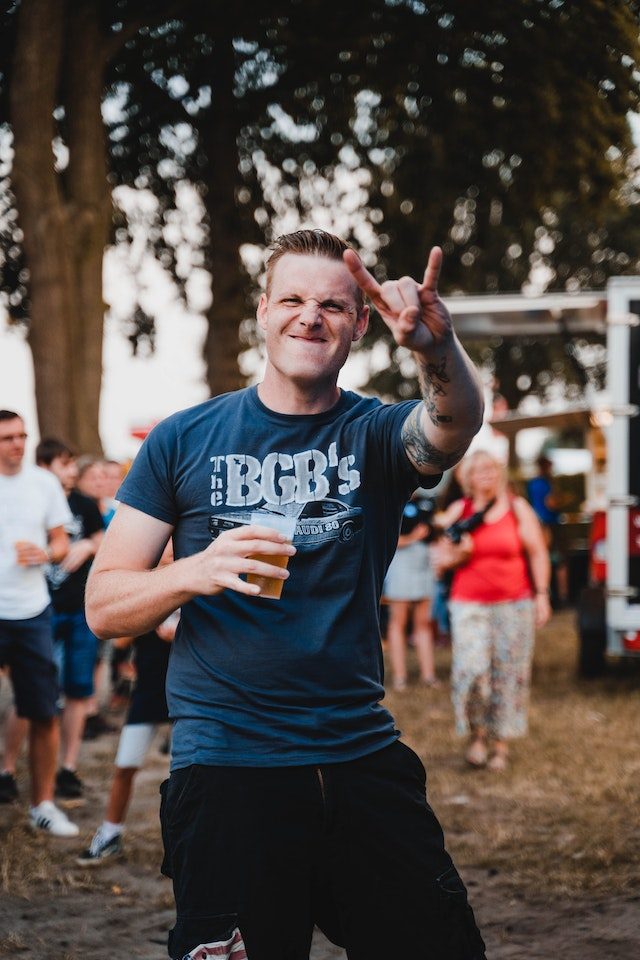

Test Image Size:,"(640, 960)"


In [56]:
test_img_name = "pexels-2769554-man-doing-rock-and-roll-sign.jpg"
test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
display(test_img)

pd.Series({
    "Test Image Size:": test_img.size, 
}).to_frame().style.hide(axis='columns')

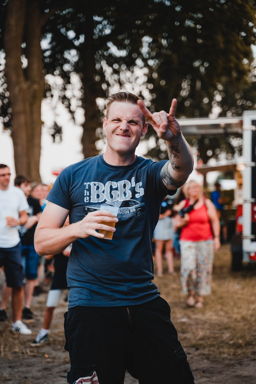

Resized Image Size:,"(256, 384)"
Input Dims:,"[256, 384]"
Offsets:,[0. 0.]
Min Image Scale:,2.500000
Input Image Size:,"(256, 384)"


In [67]:
# Set test image size
# test_sz = 384
test_sz = 256

# Resize image without cropping to multiple of the max stride
resized_img = resize_img(test_img, target_sz=test_sz, divisor=1)

# Calculating the input dimensions that multiples of the max stride
input_dims = [dim - dim % max(strides) for dim in resized_img.size]

# Calculate the offsets from the resized image dimensions to the input dimensions
offsets = (np.array(resized_img.size) - input_dims)/2

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(resized_img.size)

# Crop the resized image to the input dimensions
input_img = resized_img.crop(box=[*offsets, *resized_img.size-offsets])

display(input_img)

pd.Series({
    "Resized Image Size:": resized_img.size,
    "Input Dims:": input_dims,
    "Offsets:": offsets,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

In [68]:
# Convert the existing input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

In [69]:
%%timeit
compiled_model_int8(input_tensor_np)

3.48 ms ± 47.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
6.83/3.48

1.9626436781609196

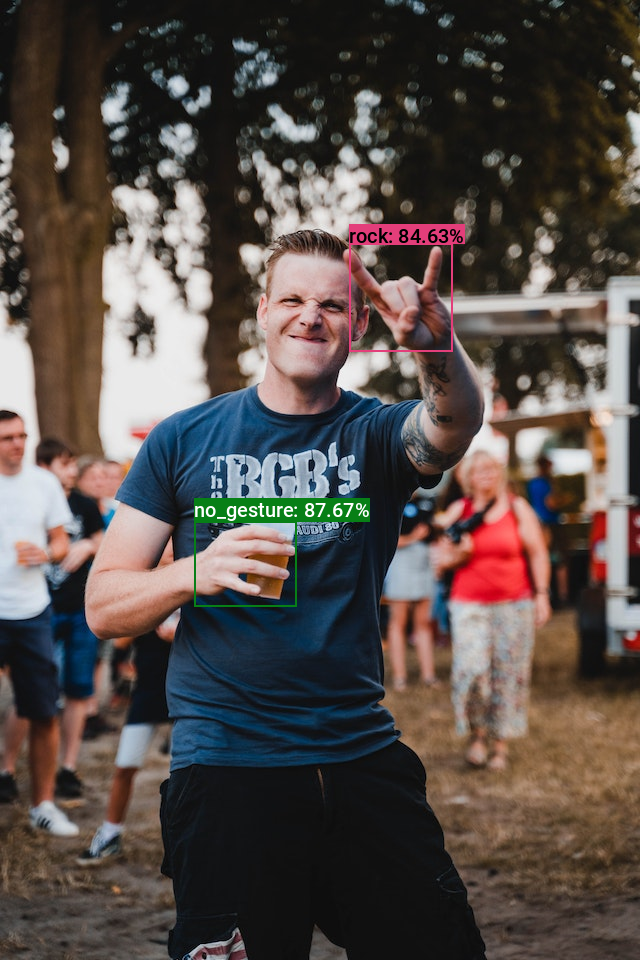

Predicted BBoxes:,"['no_gesture:[194.551 521.58 101.936 84.647]', 'rock:[349.717 243.737 103.209 108.112]']"
Confidence Scores:,"['no_gesture: 87.67%', 'rock: 84.63%']"


In [72]:
# Run inference
outputs = compiled_model_int8(input_tensor_np)[0]

# Process the model output
if not wrapped_model.run_box_and_prob_calculation:
    outputs = calculate_boxes_and_probs(outputs, generate_output_grids_np(*input_tensor_np.shape[input_dim_slice]))

bbox_conf_thresh = 0.45
iou_thresh = 0.45

# Filter the proposals based on the confidence threshold
max_probs = outputs[:, : ,-1]
mask = max_probs > bbox_conf_thresh
proposals = outputs[mask]

# Sort the proposals by probability in descending order
proposals = proposals[proposals[..., -1].argsort()][::-1]

# Apply non-max suppression to the proposals with the specified threshold
proposal_indices = nms_sorted_boxes(calc_iou(proposals[:, :-2]), iou_thresh)
proposals = proposals[proposal_indices]

bbox_list = (proposals[:,:4]+[*offsets, 0, 0])*min_img_scale
label_list = [class_names[int(idx)] for idx in proposals[:,4]]
probs_list = proposals[:,5]

annotated_img = draw_bboxes_pil(
    image=test_img, 
    boxes=bbox_list, 
    labels=label_list,
    probs=probs_list,
    colors=[int_colors[class_names.index(i)] for i in label_list], 
    font=font_file,
)

display(annotated_img)

# Print the prediction data as a Pandas Series for easy formatting
pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(label_list, bbox_list.round(decimals=3))],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(label_list, probs_list)]
}).to_frame().style.hide(axis='columns')